In [107]:
from src.acnets.deep.lemon_data import LEMONDataModule
import numpy as np
import torch
import torch.nn.functional  as F
import pywt
import matplotlib.pyplot as plt
import seaborn as sns

In [108]:

datamodule = LEMONDataModule(n_subjects=48, normalize=True)
datamodule.setup()

ts_regions = datamodule.train[0][0].numpy().T

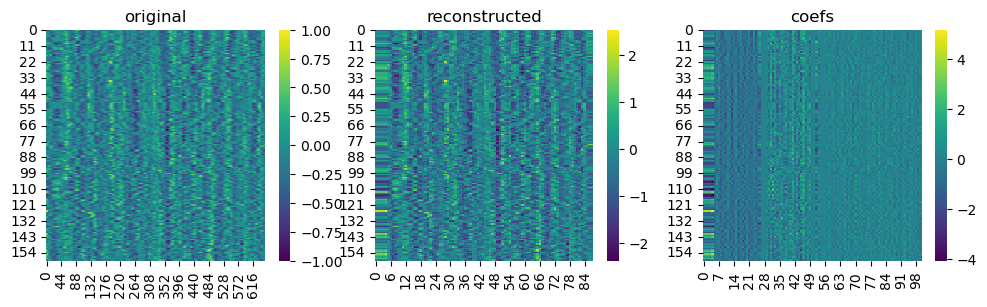

In [123]:
# Perform wavelet transform
coefs = pywt.wavedec(ts_regions, wavelet='db4', level=5)

# Analyze wavelet coefficients
# (e.g., extract features, detect patterns)

# Reconstruct the signal (optional)

# loss = F.mse_loss(torch.tensor(data).detach(),
#                   torch.tensor(data_recon).detach())
# print('MSE', loss)

n_components = 3
coefs = coefs[:3]
coefs_image = np.concatenate(coefs, axis=1)

ts_regions_recon = pywt.waverec(coefs, wavelet='db4')

plt.subplots(1, 3, figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.title('original')
sns.heatmap(ts_regions, cmap='viridis')

plt.subplot(1, 3, 2)
plt.title('reconstructed')
sns.heatmap(ts_regions_recon, cmap='viridis')

plt.subplot(1, 3, 3)
plt.title('coefs')
sns.heatmap(coefs_image, cmap='viridis')
plt.show()